# **Problem Statement:**
Develop a model to predict customer churn for a subscription based service or business. Use historical customer data, including features like usage behavior and customer demographics, and try algorithms like Logistic Regression, Random Forests, or Gradient Boosting to predict churn.

# Importing Libraries 

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import r2_score,accuracy_score,classification_report,mean_absolute_error,mean_squared_error 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [27]:
#Loading the dataset
df = pd.read_csv("https://raw.githubusercontent.com/priyankamoree/Encryptix-Internship-Tasks/main/Datasets%20For%20Internship%20Tasks/Churn_Modelling.csv")

In [28]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [29]:
#Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped.
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [31]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Exploratory Data Analysis and Visualization

In [32]:
df['Gender'].value_counts()
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

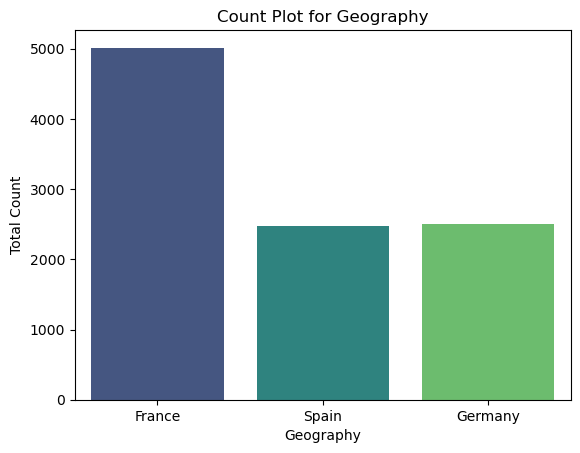

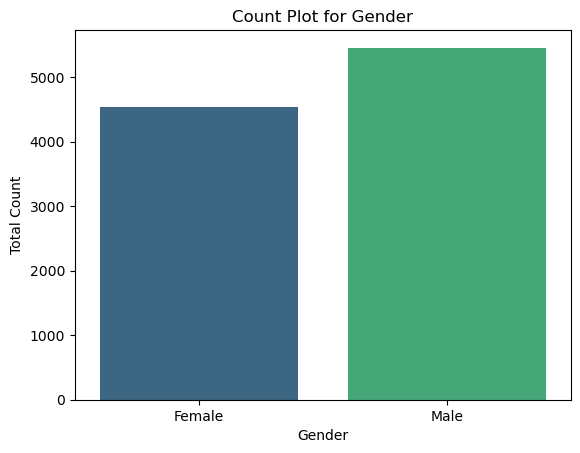

In [33]:
for i in ['Geography','Gender']:
    sns.countplot(data=df,x=df[i],orient=True,palette='viridis')
    plt.title(f"Count Plot for {i}")
    plt.xlabel(i)
    plt.ylabel("Total Count")
    plt.show()
  

In [34]:
continous = df.select_dtypes(exclude='object').columns

In [35]:
continous

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

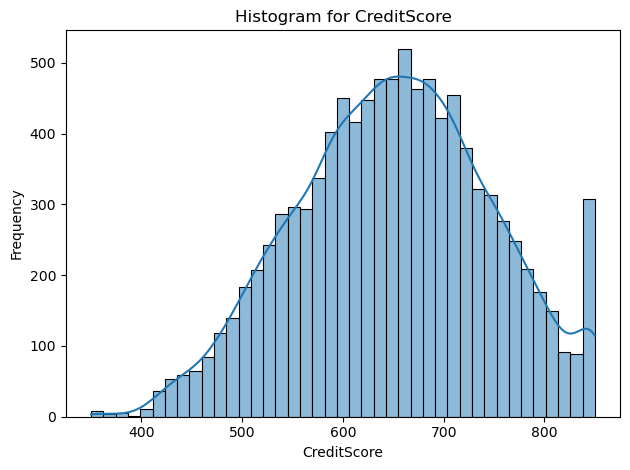

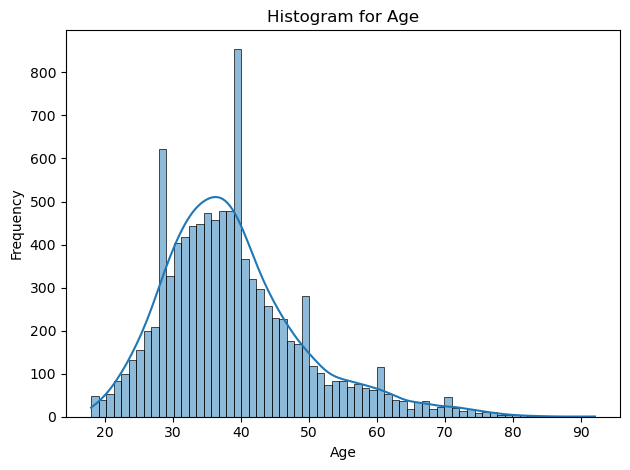

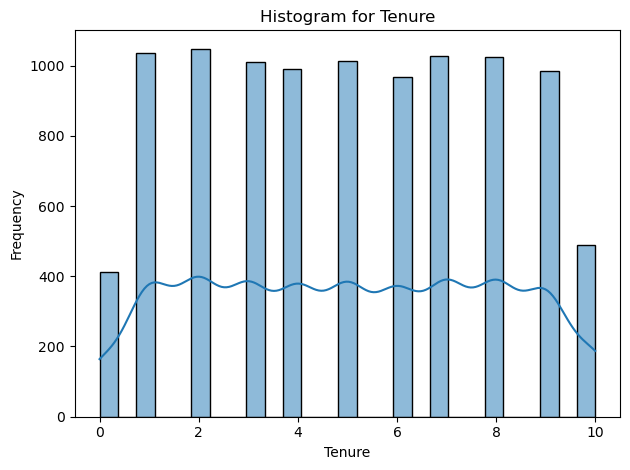

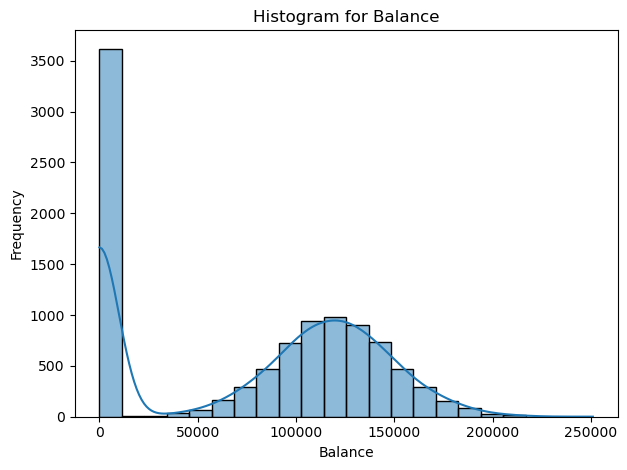

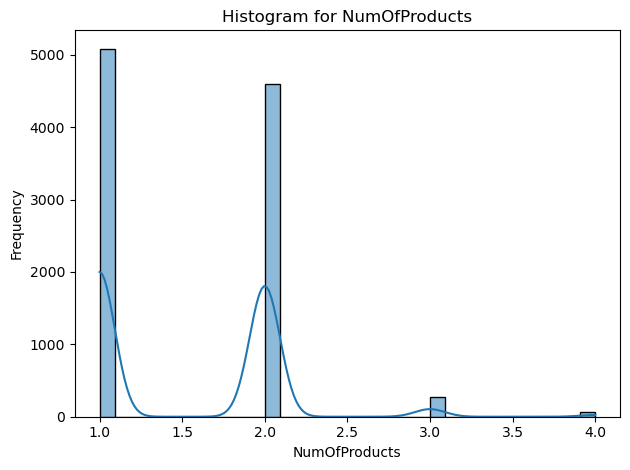

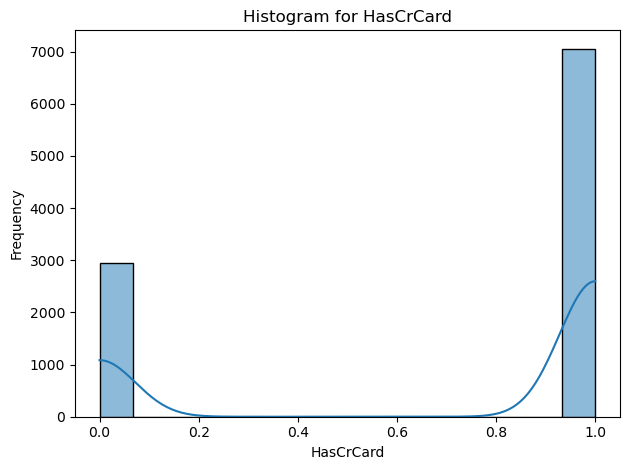

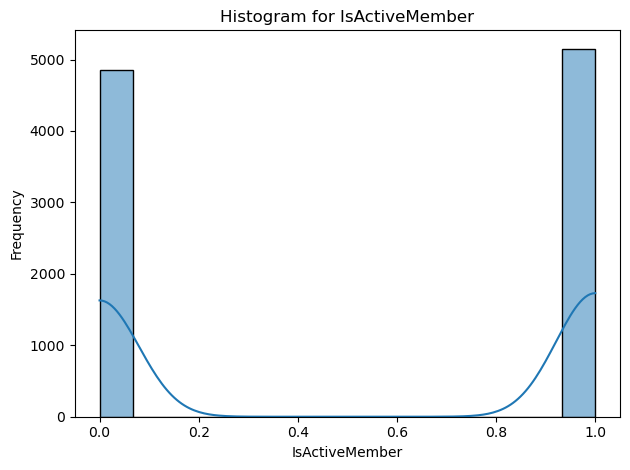

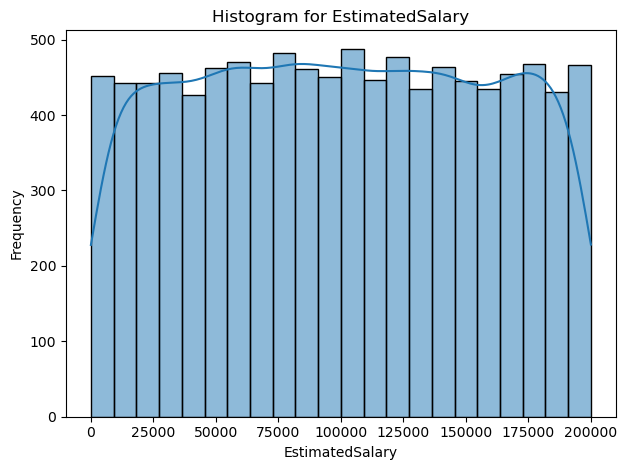

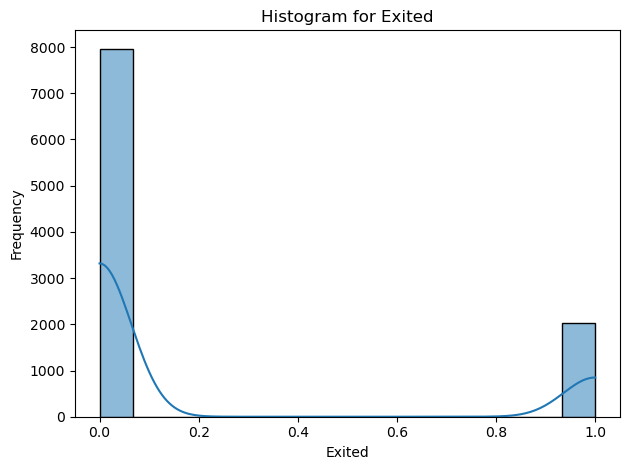

In [36]:
# Create histogram
for i in df.select_dtypes(exclude='object').columns:
    sns.histplot(df,x=df[i],bins='auto', kde='True')
    plt.title(f'Histogram for {i}')
    plt.xlabel(i)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

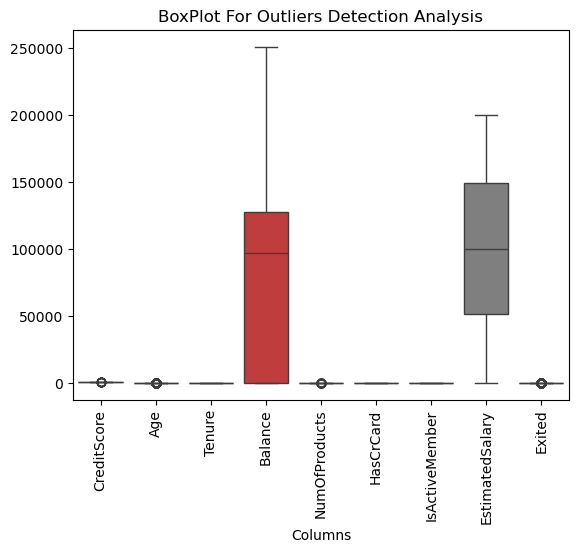

In [37]:
#Plotting BoxPlot for Outliers Detection Analysis
sns.boxplot(df)
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.title('BoxPlot For Outliers Detection Analysis')
plt.show()

# Bivariate Analysis

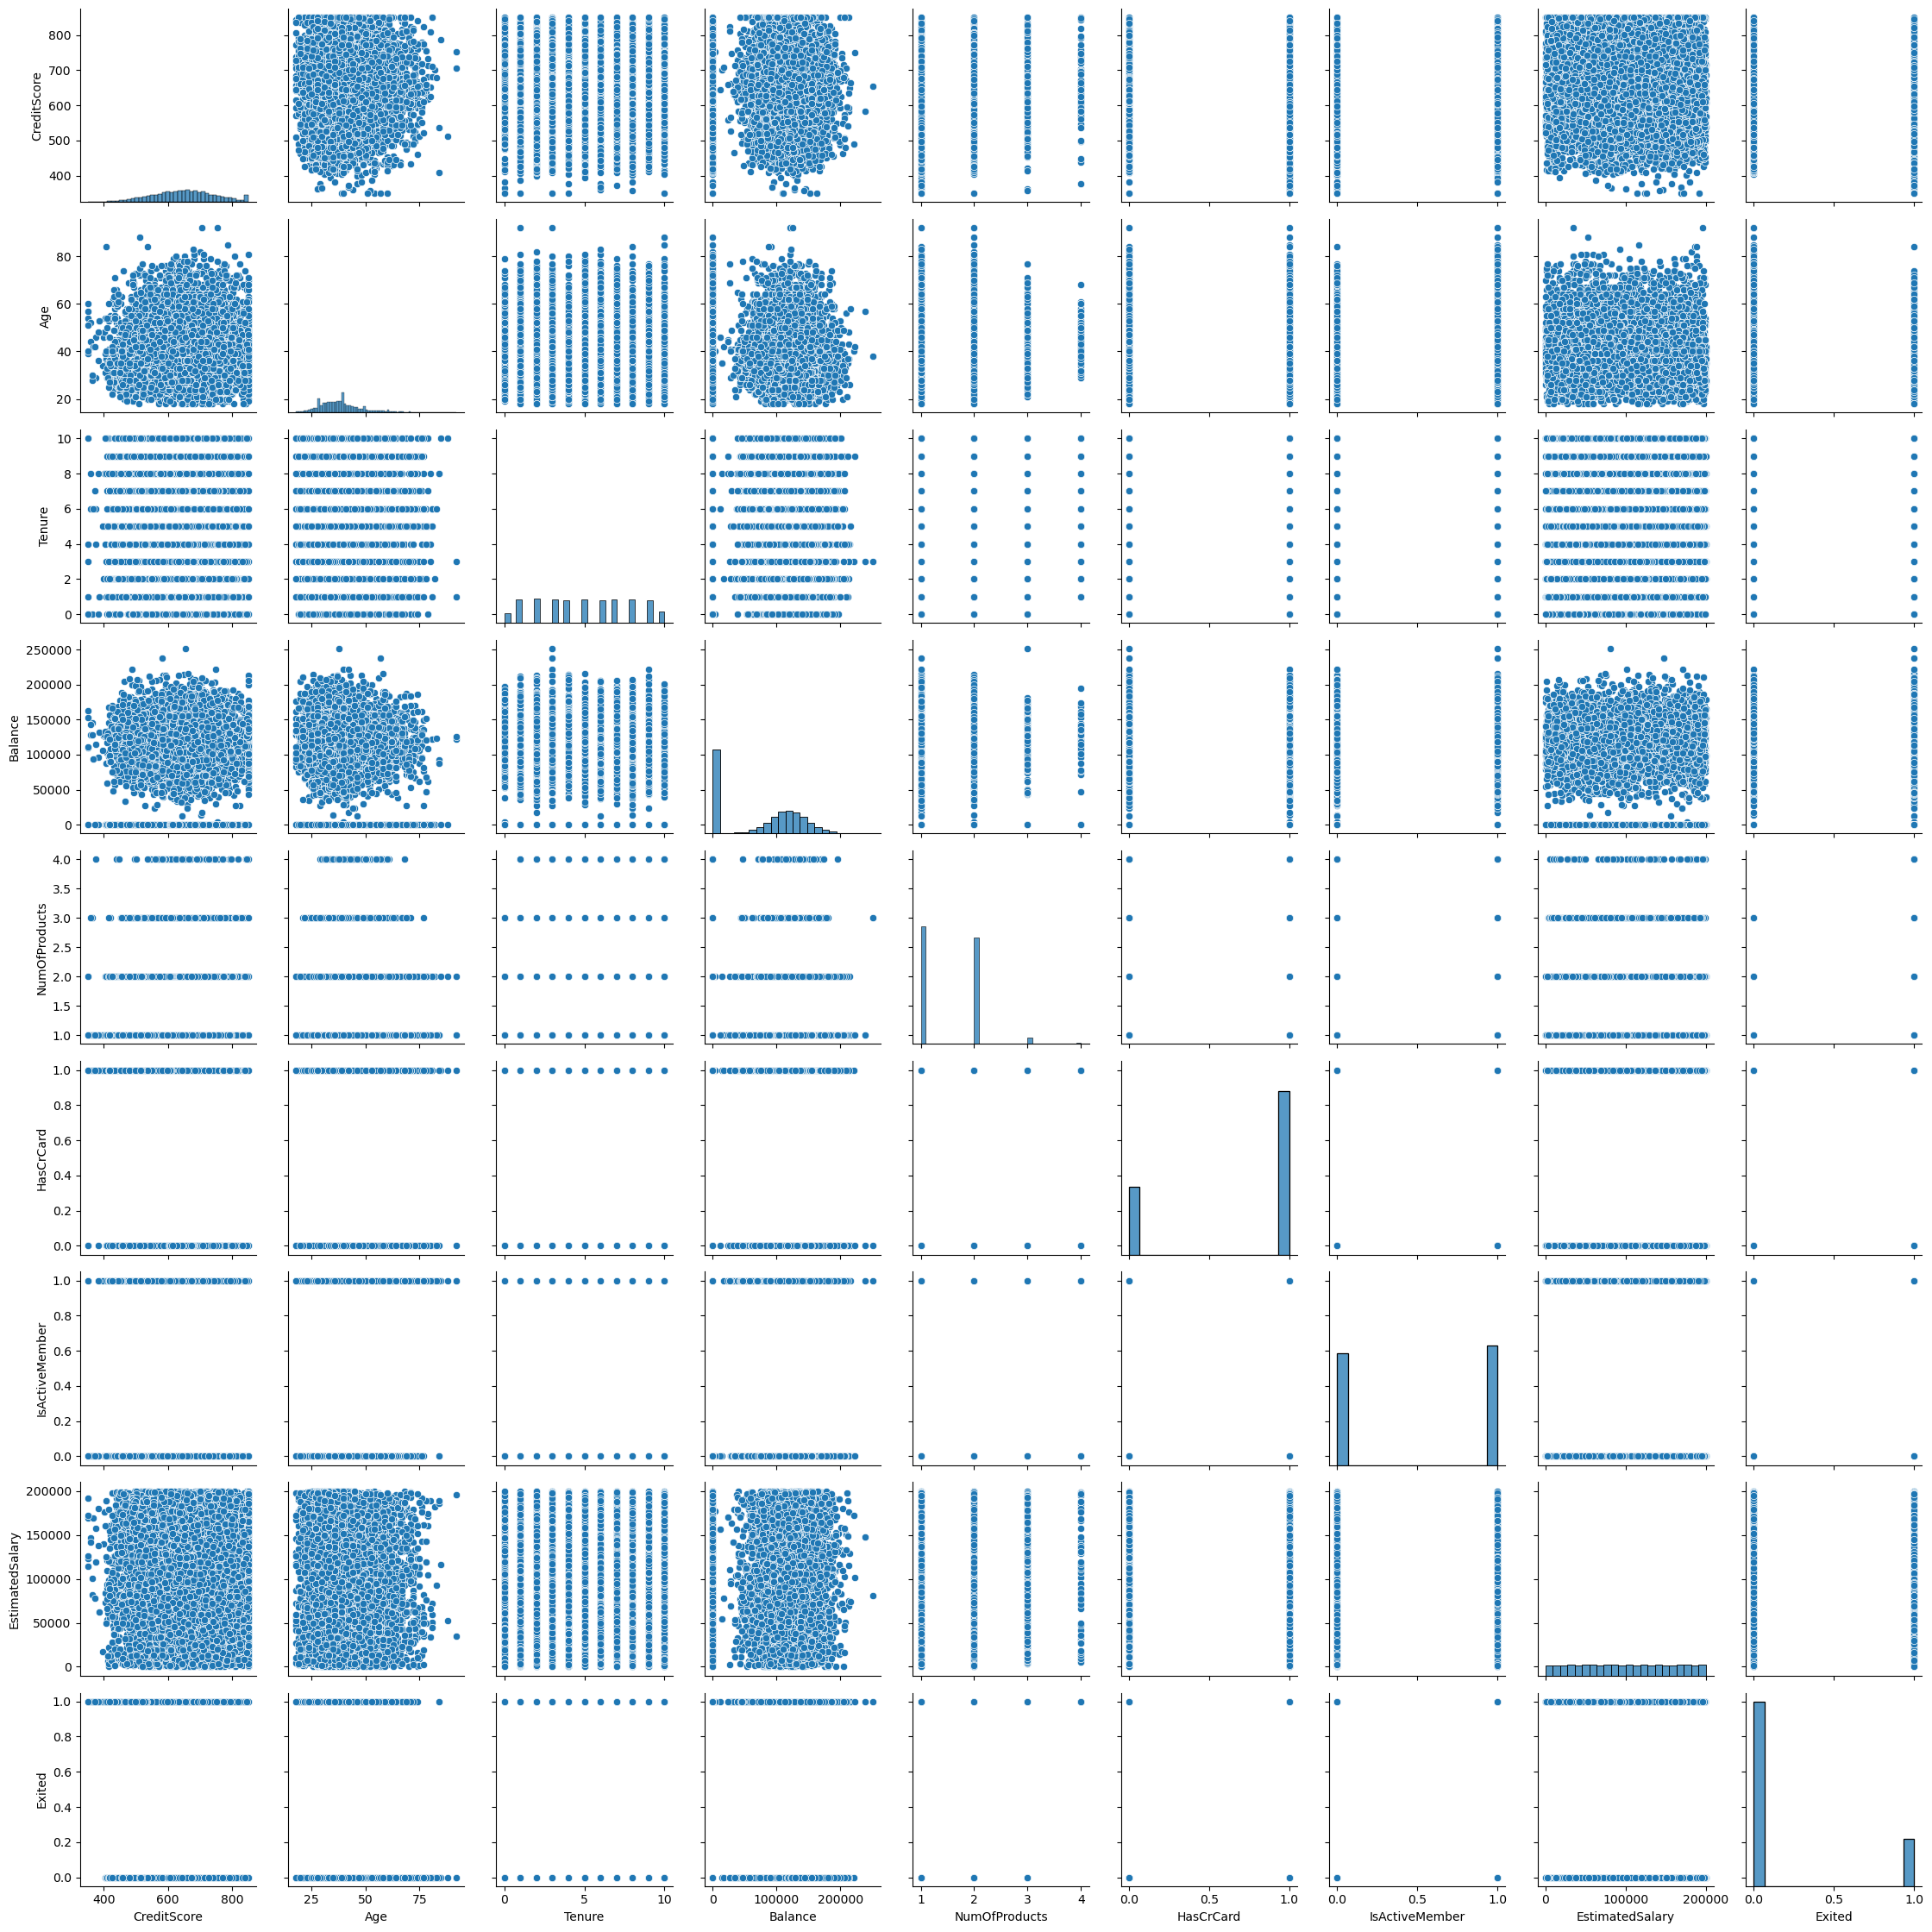

In [38]:
sns.pairplot(df)
plt.tight_layout()
plt.show()

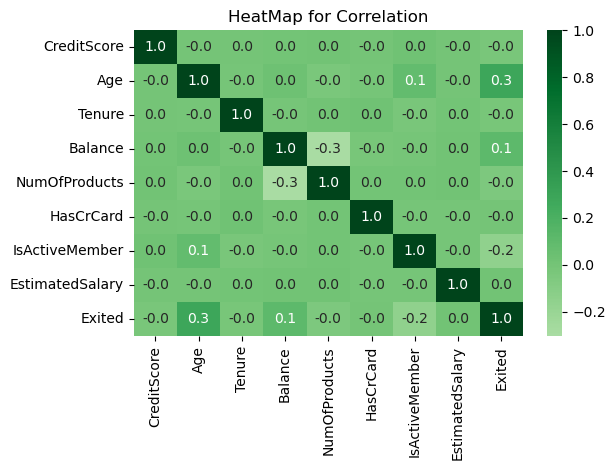

In [39]:
sns.heatmap(df.select_dtypes(exclude='object').corr(),cmap='Greens',annot=True,fmt='.1f',center=0)
plt.title('HeatMap for Correlation')
plt.tight_layout()

# Data Transformation and Data Scaling

In [40]:
#Treating Outliers which we have detected in previous Graph/Box Plot
def Treat_outliers(data, columns):
    for col in columns:
        q1= data[col].quantile(0.25)
        q3=data[col].quantile(0.75)
        iqr=q3-q1
        lower=q1-(1.5*iqr)
        upper=q3+(1.5*iqr)
        data[col]=np.where(upper<data[col],upper,np.where(lower>data[col],lower,df[col]))

In [41]:
Treat_outliers(df,df[continous])

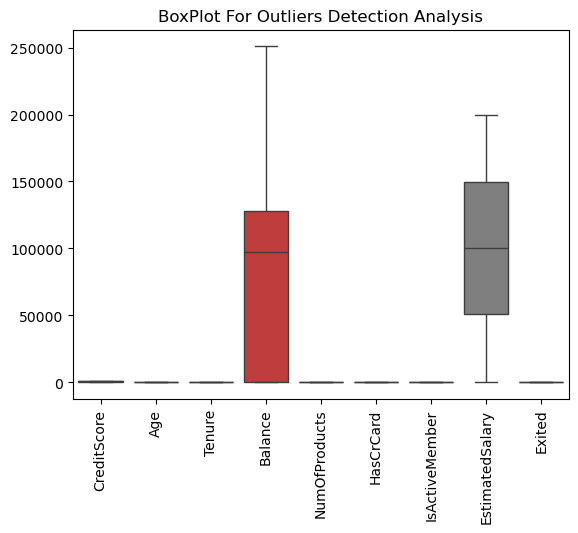

In [42]:
#Plotting BoxPlot for Outliers Detection Analysis
sns.boxplot(df)
plt.xticks(rotation=90)
plt.title('BoxPlot For Outliers Detection Analysis')
plt.show()

In [43]:
Encoded_df = pd.get_dummies(df,columns=df.select_dtypes(include='object').columns,dtype='int')
Encoded_df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619.0,42.0,2.0,0.00,1.0,1.0,1.0,101348.88,0.0,1,0,0,1,0
1,608.0,41.0,1.0,83807.86,1.0,0.0,1.0,112542.58,0.0,0,0,1,1,0
2,502.0,42.0,8.0,159660.80,3.0,1.0,0.0,113931.57,0.0,1,0,0,1,0
3,699.0,39.0,1.0,0.00,2.0,0.0,0.0,93826.63,0.0,1,0,0,1,0
4,850.0,43.0,2.0,125510.82,1.0,1.0,1.0,79084.10,0.0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771.0,39.0,5.0,0.00,2.0,1.0,0.0,96270.64,0.0,1,0,0,0,1
9996,516.0,35.0,10.0,57369.61,1.0,1.0,1.0,101699.77,0.0,1,0,0,0,1
9997,709.0,36.0,7.0,0.00,1.0,0.0,1.0,42085.58,0.0,1,0,0,1,0
9998,772.0,42.0,3.0,75075.31,2.0,1.0,0.0,92888.52,0.0,0,1,0,0,1


In [44]:
sc = StandardScaler()
df = sc.fit_transform(Encoded_df)

In [46]:
df= pd.DataFrame(df,columns=Encoded_df.columns)
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,-0.326878,0.342615,-1.041760,-1.225848,-0.924827,0.646092,0.970243,0.021886,0.0,0.997204,-0.578736,-0.573809,1.095988,-1.095988
1,-0.440804,0.240011,-1.387538,0.117350,-0.924827,-1.547768,0.970243,0.216534,0.0,-1.002804,-0.578736,1.742740,1.095988,-1.095988
2,-1.538636,0.342615,1.032908,1.333053,2.583620,0.646092,-1.030670,0.240687,0.0,0.997204,-0.578736,-0.573809,1.095988,-1.095988
3,0.501675,0.034803,-1.387538,-1.225848,0.829397,-1.547768,-1.030670,-0.108918,0.0,0.997204,-0.578736,-0.573809,1.095988,-1.095988
4,2.065569,0.445219,-1.041760,0.785728,-0.924827,0.646092,0.970243,-0.365276,0.0,-1.002804,-0.578736,1.742740,1.095988,-1.095988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.247373,0.034803,-0.004426,-1.225848,0.829397,0.646092,-1.030670,-0.066419,0.0,0.997204,-0.578736,-0.573809,-0.912419,0.912419
9996,-1.393640,-0.375612,1.724464,-0.306379,-0.924827,0.646092,0.970243,0.027988,0.0,0.997204,-0.578736,-0.573809,-0.912419,0.912419
9997,0.605244,-0.273008,0.687130,-1.225848,-0.924827,-1.547768,0.970243,-1.008643,0.0,0.997204,-0.578736,-0.573809,1.095988,-1.095988
9998,1.257730,0.342615,-0.695982,-0.022608,0.829397,0.646092,-1.030670,-0.125231,0.0,-1.002804,1.727904,-0.573809,-0.912419,0.912419


# Model Building

In [47]:
x=df.drop(columns=['Exited'])
y=df['Exited']
print(x)
print(y)

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0       -0.326878  0.342615 -1.041760 -1.225848      -0.924827   0.646092   
1       -0.440804  0.240011 -1.387538  0.117350      -0.924827  -1.547768   
2       -1.538636  0.342615  1.032908  1.333053       2.583620   0.646092   
3        0.501675  0.034803 -1.387538 -1.225848       0.829397  -1.547768   
4        2.065569  0.445219 -1.041760  0.785728      -0.924827   0.646092   
...           ...       ...       ...       ...            ...        ...   
9995     1.247373  0.034803 -0.004426 -1.225848       0.829397   0.646092   
9996    -1.393640 -0.375612  1.724464 -0.306379      -0.924827   0.646092   
9997     0.605244 -0.273008  0.687130 -1.225848      -0.924827  -1.547768   
9998     1.257730  0.342615 -0.695982 -0.022608       0.829397   0.646092   
9999     1.464868 -1.093840 -0.350204  0.859965      -0.924827   0.646092   

      IsActiveMember  EstimatedSalary  Geography_France  Geography_Germany 

In [48]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=1)

In [49]:
xtrain,xtest,ytrain,ytest

(      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
 2694    -0.233665 -0.991236 -0.695982  0.587571       0.829397  -1.547768   
 5140    -0.254379 -0.991236 -0.350204  0.469296       0.829397  -1.547768   
 2568    -0.399376  0.855635  0.341352  0.858075      -0.924827   0.646092   
 3671    -0.047241  1.368654  0.341352  0.565012       0.829397  -1.547768   
 7427     0.657029 -0.580820  1.032908  0.729735      -0.924827  -1.547768   
 ...           ...       ...       ...       ...            ...        ...   
 2895    -0.306164  0.855635  0.687130  0.494875      -0.924827   0.646092   
 7813     0.346322  2.394693 -0.695982  0.076287      -0.924827   0.646092   
 905      0.222039  0.650427  1.378686 -1.225848      -0.924827   0.646092   
 5192     0.128827  0.034803  1.032908 -1.225848       0.829397   0.646092   
 235      1.164518  0.342615  0.341352  0.379440      -0.924827   0.646092   
 
       IsActiveMember  EstimatedSalary  Geography_France  Geog

In [50]:
rf = RandomForestClassifier()
rf.fit(xtrain,ytrain)
ypred = rf.predict(xtest)
ypred

array([0., 0., 0., ..., 0., 0., 0.])

In [52]:
accuracy_score(ytest,ypred)

1.0

# Model Evaluation

In [56]:
#Model Evaluation Metrics
print(f"Accuracy Score: {accuracy_score(ytest,ypred)}")
print(f"MSE:{mean_squared_error(ytest,ypred)}")
print(f"R2Score: {r2_score(ytest,ypred)}")
print(f"Classification Report: {classification_report(ytest,ypred)}")

Accuracy Score: 1.0
MSE:0.0
R2Score: 1.0
Classification Report:               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

